In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
from PIL import Image
import requests
import cv2
import subprocess
import os
sns.set_style('darkgrid')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#create an empty DataFrame
df = pd.DataFrame(columns=['path','label'])
 
#loop over fire images and label them 1
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'Fire']],columns=['path','label']))
 
#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'No Fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))
 
#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,/content/drive/MyDrive/Dataset/fire_dataset/no...,No Fire
1,/content/drive/MyDrive/Dataset/fire_dataset/no...,No Fire
2,/content/drive/MyDrive/Dataset/fire_dataset/no...,No Fire
3,/content/drive/MyDrive/Dataset/fire_dataset/fi...,Fire
4,/content/drive/MyDrive/Dataset/fire_dataset/fi...,Fire
5,/content/drive/MyDrive/Dataset/fire_dataset/fi...,Fire
6,/content/drive/MyDrive/Dataset/fire_dataset/fi...,Fire
7,/content/drive/MyDrive/Dataset/fire_dataset/fi...,Fire
8,/content/drive/MyDrive/Dataset/fire_dataset/fi...,Fire
9,/content/drive/MyDrive/Dataset/fire_dataset/no...,No Fire


In [ ]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.1,
)
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning:

Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.



Found 1662 validated image filenames belonging to 2 classes.
Found 184 validated image filenames belonging to 2 classes.
{0: 'Fire', 1: 'No Fire'}


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning:

Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.



#Load Pre Trained Model
###If you load the pretrained model then avoid the training section

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks')
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

6/6 [==============================] - 48s 9s/step - loss: 0.1366 - accuracy: 0.9402 - recall: 0.9221 - auc: 0.9884
loss: 0.14
accuracy: 0.94
recall: 0.92
auc: 0.99


#Test An Image From Drive

> Indented block


###Paste The Test Image Path in img

The Given Input Image Is: 
The predicted value is:  True and the predicted label is: Fire


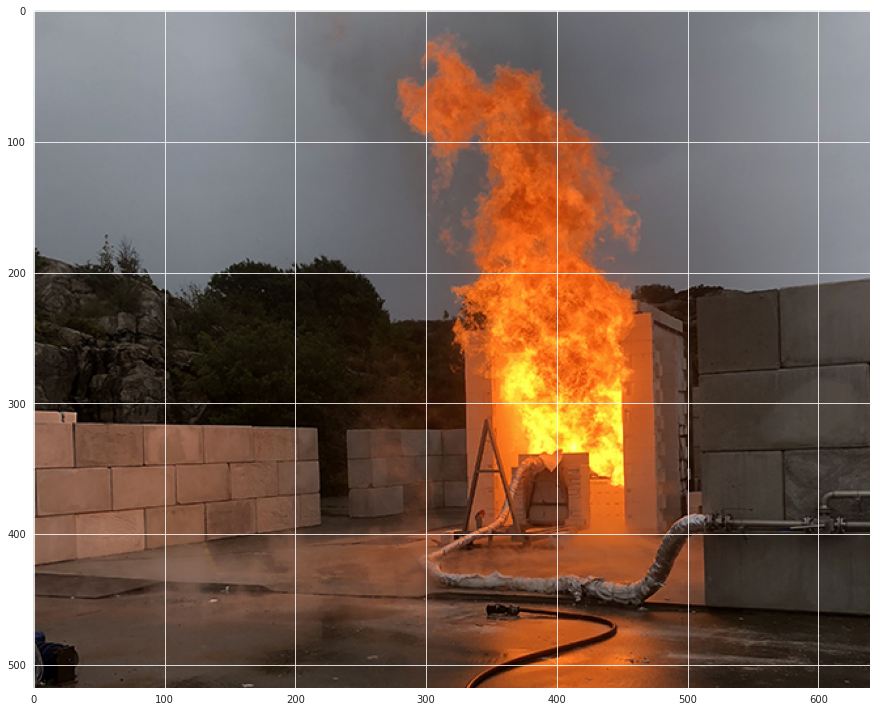

In [ ]:
img = image.load_img('/content/drive/MyDrive/firetest.jpg')
print('The Given Input Image Is: ')
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(img)
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)
prediction = int(tf.round(model.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",not prediction,"and the predicted label is:",class_indices[prediction])

#Test An Image From URL
###Paste The Image From Any URL and get a prediction

The Given Image Is: 
The predicted value is:  False and the predicted label is: No Fire


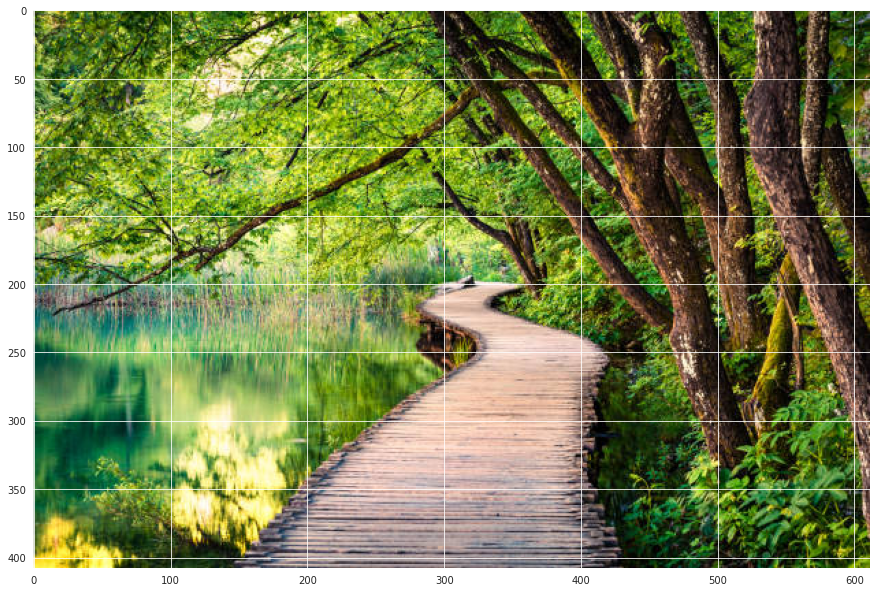

In [ ]:
img_url='https://media.istockphoto.com/photos/picturesque-morning-in-plitvice-national-park-colorful-spring-scene-picture-id1093110112?k=6&m=1093110112&s=612x612&w=0&h=uBH7Rj-Ew_ixjunRrD_U7alq2ZUPJ_5XgMpe9xO52QQ='
print('The Given Image Is: ')
Image.open(requests.get(img_url, stream=True).raw)
img = Image.open(requests.get(img_url, stream=True).raw)
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(img)
img=np.asarray(img)
img = (img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)
prediction = int(tf.round(model.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",not prediction,"and the predicted label is:",class_indices[prediction])


#Training Part (If You Loaded The Pre Trained Model Then Ignore This)

In [ ]:
 model = Sequential()
 model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
 model.add(MaxPool2D())
 model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
 model.add(MaxPool2D())
 model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
 model.add(MaxPool2D())
 model.add(Flatten())
 model.add(Dense(64,activation='relu'))
 model.add(Dense(32,activation = 'relu'))
 model.add(Dense(1,activation = 'sigmoid'))
 model.summary()
 model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])
 reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)
 early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
 model.fit(x=train_gen,batch_size=32,epochs=50,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])
 model.save('/content/drive/MyDrive/Colab Notebooks')

#Evaluation Of The Model's Performance

In [ ]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

6/6 [==============================] - 11s 2s/step - loss: 0.1260 - accuracy: 0.9565 - recall: 0.9481 - auc: 0.9908
loss: 0.13
accuracy: 0.96
recall: 0.95
auc: 0.99


#Video Classification
###Input The Location of video in input video

In [ ]:
from time import sleep

In [ ]:
input_video = cv2.VideoCapture('/content/drive/MyDrive/Sample Video.mp4')
width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH ))
height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT ))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video= cv2.VideoWriter('/content/drive/MyDrive/temporary no sound.avi', fourcc, 30,
			(width,height), True)
frame_count = int(input_video. get(cv2. CAP_PROP_FRAME_COUNT))
frame_no=0
counting_frame=np.arange(0,frame_count,30)
fire_predicted=[]
fire_frame=[]
no_fire_frame=[]

while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = input_video.read()
    if ret==True:
      prediction=[]
      captured=frame.copy()
      if frame_no in counting_frame:
        cv2.imwrite('filename.jpeg', frame)
        frame = image.load_img('/content/filename.jpeg')
        frame = image.img_to_array(frame)/255
        frame = tf.image.resize(frame,(256,256))
        frame = tf.expand_dims(frame,axis=0)
        sleep(1)
        prediction = int(tf.round(model.predict(x=frame)).numpy()[0][0])
        label=class_indices[prediction]
       # print(label)
      text = "Condition: {}".format(label)
      frame_no=frame_no+1
      cv2.putText(captured, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
                  1.25, (0, 255, 0), 5)
      output_video.write(captured)
      if label=='Fire':
        fire_frame.append(frame_no)
      if label=='No Fire':
        no_fire_frame.append(frame_no)
    else:
      break
input_video.release()
cv2.destroyAllWindows()
output_video.release()

#Name The Output Video
Just Name The output video in (labelled_video) and your classified video will be saved in google drive

In [ ]:
labelled_video='Output'
input='/content/drive/MyDrive/temporary no sound.avi'
input_alarm='/content/drive/MyDrive/Colab Notebooks/Popular Alarm Clock Sound Effect (1).mp3'
output_video_sounded='/content/drive/MyDrive/{}.avi'.format(labelled_video)
time=int(fire_frame[60]/30)
cmd='ffmpeg -y -i "{}" -itsoffset 00:00:{} -i "{}" -map 0:0 -map 1:0 -c:v copy -preset ultrafast -async 1 "{}"'.format(input,time,input_alarm,output_video_sounded)
subprocess.call(cmd, shell=True)
os.remove(input)

#Check The Condtion Through A Webcam

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Audio
 
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
 
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
 
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
 
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
sound = "/content/drive/MyDrive/Colab Notebooks/Popular Alarm Clock Sound Effect (1).wav"
FireLabelCount=0;
while(True):
  filename = take_photo()
  frame = image.load_img('/content/photo.jpg')
  frame = image.img_to_array(frame)/255
  frame = tf.image.resize(frame,(256,256))
  frame = tf.expand_dims(frame,axis=0)
  prediction = int(tf.round(model.predict(x=frame)).numpy()[0][0])
  label=class_indices[prediction]
  if label=='Fire':
    FireLabelCount+=1;
  else:
    FireLabelCount=0;
  if FireLabelCount==5:
    display(Audio(sound, autoplay=True))
  print(label)
  if cv2.waitKey(1) & 0xFF == ord('q'):
          break

AttributeError: ignored